<a href="https://colab.research.google.com/github/plinder-org/moving_beyond_memorisation/blob/main/notebooks/plinder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Please run only the first cell, wait for the kernel to restart, and then continue with the second cell

In [1]:
!pip install -q git+https://github.com/conda-incubator/condacolab.git@0.1.x
import condacolab
condacolab.install()

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:10
🔁 Restarting kernel...


In [2]:
!mamba install -q pip scipy networkx conda-forge::boost aivant::openstructure anaconda::py-boost plip
!pip install -q networkit tabulate
!pip install -q pdb-validation@git+https://git.scicore.unibas.ch/schwede/ligand-validation.git
!pip install -q mmpdb@git+https://github.com/rdkit/mmpdb.git
!pip install -q plinder@git+https://github.com/plinder-org/plinder@revamp_loader
!pip install -q py3Dmol

Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 86.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 446.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 617.5/617.5 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 94.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.9/229.9 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.0/378.0 kB 20.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Downloading the dataset

The default location for the dataset is `~/.local/share/pinder/<PLINDER_RELEASE>/<PLINDER_ITERATION>` where:
- `<PLINDER_RELEASE>` is the date of the PDB sync used to generate the dataset (e.g 2024-06)
- `<PLINDER_ITERATION>` is the iteration of the source code that generated the dataset (e.g. `v2`)

If you want to use a different location, you can do so by setting the `PLINDER_MOUNT` environment variable. For example, in the Google Colab context we could set it to "/content" so that we can see the files in the file browser.


In [2]:
%env PLINDER_LOG_LEVEL=0
%env PLINDER_MOUNT=/content

env: PLINDER_LOG_LEVEL=0
env: PLINDER_MOUNT=/content



### Use `plinder_download` to download the complete dataset

```bash
plinder_download --help
usage:
    Download the full plinder dataset for the current configuration.
    Note that even though this is wrapped in a progress bar, the estimated
    completion time can vary wildly as it iterates over larger files vs.
    smaller ones.
    

optional arguments:
  -h, --help            show this help message and exit
  --release RELEASE     plinder release
  --iteration ITERATION
                        plinder iteration
  -y, --yes             skip confirmation
```

**NOTE: _This will take around an hour to complete and downloads around 1TB of data_**.

But after this is done you can set the `PLINDER_OFFLINE` environment variable to `true` to avoid downloading the data again.

### Use the `plinder` Python package to lazily access the dataset

Alternatively, if the `PLINDER_OFFLINE` environment variable is set to `false` (which is the default), the dataset will be downloaded on lazily and on the fly as you access the data. This is preferred for exploration and prototyping as you don't need to download the entire dataset at once and can just work with the assets you need for your use-case.

In [3]:
import plinder.core.utils.config

cfg = plinder.core.get_config()
print(f"local directory: {cfg.data.plinder_dir}")
print(f"remote data directory: {cfg.data.plinder_remote}")

/usr/local/lib/python3.10/dist-packages/google/cloud/storage/transfer_manager.py:30: UserWarning: The module `transfer_manager` is a preview feature. Functionality and API may change. This warning will be removed in a future release.
  warnings.warn(


local directory: /content/plinder/2024-06/v2
remote data directory: gs://plinder/2024-06/v2


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import py3Dmol

# The PLINDEX


## Querying and filtering the index

Your main entry point to the dataset is the annotations table or the **index**, which is a Parquet file containing all the annotations for each system in the dataset.

**NOTE: _The entire file has 745 columns, >1.3M rows, and takes 24G of RAM to load into memory_**

We provide a `query_index` function to access the index and filter it based on the columns and criteria you need.

In [5]:
from plinder.core.scores import query_index

The core of the PLINDER dataset is a collection of Protein-Ligand Interaction (PLI) systems extracted from the Protein Data Bank (PDB). The curation process in a nutshell is as follows:

1. For every PDB entry, we generate all available biological assemblies (biounits).
2. For each biounit, we identify all ligands and all protein chains within 6 Å of any ligand.
3. Ligands within 4 Å of each other are merged into a single PLI system.
4. For each system, we provide a range of detailed annotations and files to facilitate in-depth analysis and to enable a variety of use-cases.

Thus, a PLI **_system_** is defined as a collection of **_protein_** and **_ligand_** chains that are in close proximity to each other within a given **_biounit_** of a given PDB **_entry_**. The **_pocket_** of a system is defined as the set of protein residues within 6 Å of the ligands in the system.

Let's look at all the columns that define a `system`:

In [6]:
plindex = query_index(
    columns=[
        "system_id",
        "entry_pdb_id",
        "system_biounit_id",
        "system_protein_chains_asym_id",
        "system_ligand_chains_asym_id",
        "ligand_instance_chain",
    ]
)
plindex.head(20)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,system_id,entry_pdb_id,system_biounit_id,system_protein_chains_asym_id,system_ligand_chains_asym_id,ligand_instance_chain,split
0,3grt__1__1.A_2.A__1.B,3grt,1,"[1.A, 2.A]",[1.B],1.B,train
1,3grt__1__1.A_2.A__1.C,3grt,1,"[1.A, 2.A]",[1.C],1.C,train
2,3grt__1__1.A_2.A__2.B,3grt,1,"[1.A, 2.A]",[2.B],2.B,train
3,3grt__1__1.A_2.A__2.C,3grt,1,"[1.A, 2.A]",[2.C],2.C,train
4,1grx__1__1.A__1.B,1grx,1,[1.A],[1.B],1.B,train
5,6grf__1__1.A__1.D,6grf,1,[1.A],[1.D],1.D,train
6,6grf__2__1.B__1.E,6grf,2,[1.B],[1.E],1.E,train
7,3grj__2__1.B__1.I_1.L_1.Q,3grj,2,[1.B],"[1.I, 1.L, 1.Q]",1.I,train
8,3grj__2__1.B__1.I_1.L_1.Q,3grj,2,[1.B],"[1.I, 1.L, 1.Q]",1.L,train
9,3grj__2__1.B__1.I_1.L_1.Q,3grj,2,[1.B],"[1.I, 1.L, 1.Q]",1.Q,train


Thus, a system is uniquely qualified by its `system_id` which is a combination of
- `entry_pdb_id` - the PDB identifier
- `system_biounit_id` - the biological assembly identifier
- `system_protein_chains_asym_id` - The list of protein chains in the system defined by their `<instance>.<label_asym_id>`
- `system_ligand_chains_asym_id` - The list of ligand chains in the system defined by their `<instance>.<label_asym_id>`

Systems containing multiple ligands (e.g `4grc__1__1.A__1.C_1.D`) span multiple rows, where each row represents a different ligand in the system (as seen in the `ligand_instance_chain` column).

In [7]:
print(f"Number of ligands: {plindex.shape[0]}")
print(f"Number of systems: {plindex.system_id.nunique()}")
print(
    f"Number of biounits: {plindex[['entry_pdb_id', 'system_biounit_id']].drop_duplicates().shape[0]}"
)
print(f"Number of PDB IDs: {plindex.entry_pdb_id.nunique()}")

Number of ligands: 419538
Number of systems: 309972
Number of biounits: 108206
Number of PDB IDs: 77474


While `query_index` by default loads all the systems in the `train` and `val` splits, not every returned system may be useful for training your model.

In [8]:
plindex = query_index(
    columns=[
        "system_id",
        "system_num_protein_chains",
        "system_num_ligand_chains",
        "system_type",
        "ligand_is_ion",
        "ligand_is_artifact",
        "ligand_is_cofactor",
        "ligand_is_fragment",
    ]
)

You may only be interested in systems with a certain number of protein or ligand chains, or you may want to exclude systems with ions or cofactors:

In [9]:
plindex.system_num_protein_chains.value_counts()

,count
system_num_protein_chains,
1,260142
2,131014
3,23306
4,4466
5,610


In [10]:
plindex.system_num_ligand_chains.value_counts()

,count
system_num_ligand_chains,
1,230146
2,115122
3,48447
4,19028
5,6795


In [11]:
plindex.ligand_is_ion.value_counts()

,count
ligand_is_ion,
False,374553
True,44985


In [12]:
plindex.ligand_is_artifact.value_counts()

,count
ligand_is_artifact,
False,389915
True,29623


In [13]:
plindex.ligand_is_fragment.value_counts()

,count
ligand_is_fragment,
False,382768
True,36770


In [14]:
plindex.ligand_is_cofactor.value_counts()

,count
ligand_is_cofactor,
False,337914
True,81624


### Single-ligand single-protein predictors

As an example, we consider the case of training single-ligand single-protein models. One way to filter training data is as follows:

In [15]:
plindex_single = query_index(
    filters=[
        ("system_num_ligand_chains", "==", 1),
        ("system_num_protein_chains", "==", 1),
    ],
    splits=["train"],
)

In [16]:
plindex_single.system_id.nunique()

152822

However, as PLINDER also considers ions and crystallization artifacts as ligands if they are within 4 Å of a non-ion non-artifact ligand, there are also systems in PLINDER which only have one "proper" ligand. So, another strategy would be to only train on the proper ligands and ignore the ions and artifacts in the system.

In [17]:
plindex_single_proper = query_index(
    filters=[
        ("system_proper_num_ligand_chains", "==", 1),
        ("system_num_protein_chains", "==", 1),
        ("ligand_is_proper", "==", True),  # filters out all other ligands in the system
    ],
    splits=["train"],
)

In [18]:
plindex_single_proper.system_id.nunique()

182360

This can provide up to 20% more data for training, however, the caveat is that some of the interactions made by artifacts or ions may influence the binding pose of the "proper" ligand.

One could also choose to include multi-ligand systems but only train with one ligand at a time, and the same for multi-protein. These choices are up to the user and we provide the annotations to enable such choices.

## Annotations

There are 745 columns in the full index. Of course, not every one will be useful for your use-case so we'll go through some common categories of them and some  use-cases requiring different annotations. You can get the full list of columns with descriptions as below, and these are also described in the [index docs](https://plinder-org.github.io/plinder/dataset.html#annotation-tables-index).

In [19]:
from plinder.data.docs import get_all_column_descriptions

column_descriptions = get_all_column_descriptions()
column_descriptions

,Name,Type,Description
0,ligand_asym_id,str,Ligand chain asymmetric id
1,ligand_instance,int,Biounit instance ID
2,ligand_ccd_code,str,Ligand Chemical Component Dictionary (CCD) code
3,ligand_plip_type,str,PLIP ligand type
4,ligand_bird_id,str,Ligand BIRD id
...,...,...,...
740,ligand_neighboring_ligand_chains_validation_ma...,list[int],The highest number of configurations in a sing...
741,ligand_neighboring_ligand_chains_validation_pe...,list[float],Percent outliers for chirality
742,ligand_neighboring_ligand_chains_validation_pe...,list[float],Percent outliers for clashes
743,ligand_neighboring_ligand_chains_validation_pe...,list[float],Percent outliers for density


### Structure quality

A core principle of PLINDER is to be able to annotate which systems are of high enough experimental structure quality to be reliably used as the _ground truth_ for measuring model performance. As the quality of experimentally resolved structures [can vary significantly](https://doi.org/10.1107/S2059798322011901) and many crystal structures with ligands contain missing atoms or missing residues in the binding site, comparing prediction results to lower quality structures can incorrectly skew the perception of their performance.

![quality](https://www.plinder.sh/blog/figure2.png)


You can access all the crystal structure validation information extracted from PDB validation reports as well as crystal contact annotations by looking for columns starting with "entry_validation", "system_pocket_validation", "system_ligand_validation" etc.

In [20]:
column_descriptions[column_descriptions["Name"].str.startswith("entry_validation")]

,Name,Type,Description
361,entry_validation_resolution,float,Resolution of the PDB entry
362,entry_validation_rfree,float,The similarity between the observed structure-...
363,entry_validation_r,float,The similarity between the observed structure-...
364,entry_validation_clashscore,float,The Molprobity Clashscore is an approximation ...
365,entry_validation_percent_rama_outliers,float | None,The percentage of Ramachandran outliers with r...
366,entry_validation_percent_rota_outliers,float | None,The percentage of residues with an unusual sid...
367,entry_validation_data_completeness,float | None,The number of expected diffraction spots is a ...
368,entry_validation_percent_RSRZ_outliers,float | None,The percentage Real-Space R-value Z-score outl...
369,entry_validation_atom_count,int,Number of atoms in the asymmetric unit of the ...
370,entry_validation_molprobity,float | None,"Overall Molprobity ""effective resolution"", a s..."


In [21]:
column_descriptions[
    column_descriptions["Name"].str.startswith("system_pocket_validation")
]

,Name,Type,Description
321,system_pocket_validation_num_residues,int,Number of residues in the list
322,system_pocket_validation_num_processed_residues,int,Number of processed residues in the list
323,system_pocket_validation_percent_processed_res...,float,Percentage of processed residues in the list
324,system_pocket_validation_average_rsr,float,Average Real-Space R-value across all residues...
325,system_pocket_validation_average_rsrz,float,Average Real-Space R-value Z-score across all ...
326,system_pocket_validation_average_rscc,float,Average Real-Space Correlation Coefficient acr...
327,system_pocket_validation_average_occupancy,float,Average occupancy across all residues in the list
328,system_pocket_validation_percent_rsr_under_thr...,float,Percentage of residues with RSR under the thre...
329,system_pocket_validation_percent_rscc_over_thr...,float,Percentage of residues with RSCC over the thre...
330,system_pocket_validation_percent_occupancy_ove...,float,Percentage of residues with occupancy over the...


For simplicity, we have "system_pass_validation_criteria" as a column that can be used to filter systems which pass our quality definitions:

```python
class QualityCriteria:
    max_entry_resolution: float = 3.5
    max_entry_r: float = 0.4
    max_entry_rfree: float = 0.45
    max_entry_r_minus_rfree: float = 0.05
    ligand_max_num_unresolved_heavy_atoms: int = 0
    ligand_max_alt_count: int = 1  # misnomer: this counts number of total configurations
    ligand_min_average_occupancy: float = 0.8
    ligand_min_average_rscc: float = 0.8
    ligand_max_average_rsr: float = 0.3
    ligand_max_percent_outliers_clashes: float = 0
    ligand_max_fraction_atoms_with_crystal_contacts: float = 0
    pocket_max_num_unresolved_heavy_atoms: int = 0
    pocket_max_alt_count: int = 1  # same as above
    pocket_min_average_occupancy: float = 0.8
    pocket_min_average_rscc: float = 0.8
    pocket_max_average_rsr: float = 0.3
    pocket_max_percent_outliers_clashes: int = 100
```

In [22]:
plindex = query_index(
    columns=["system_id", "system_pass_validation_criteria"],
    splits=["train", "val", "test"],
)

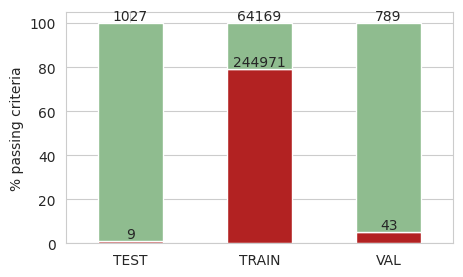

In [23]:
data = (
    plindex.drop_duplicates("system_id")
    .sort_values(by="system_pass_validation_criteria")
    .groupby(["split", "system_pass_validation_criteria"])
    .system_id.count()
    .unstack()
)
data_percentage = data.div(data.sum(axis=1), axis=0) * 100
ax = data_percentage.plot(
    kind="bar", stacked=True, figsize=(5, 3), color=["firebrick", "darkseagreen"]
)
ax.set_xticklabels(
    [label.get_text().upper() for label in ax.get_xticklabels()], rotation=0
)
ax.set_xlabel("")
ax.set_ylabel("% passing criteria")
ax.get_legend().remove()
for container, count_data in zip(ax.containers, data.values.T):
    ax.bar_label(container, labels=count_data, label_type="edge")

### Structure completeness

Related to structure quality, one aspect that is important to consider when using these structures in your training is **completeness**. While the inputs for prediction may be a protein sequence and a SMILES string, the protein-ligand complex structure that you get from the PDB may not have all the residues in the protein or all the atoms in the ligand resolved.

In [24]:
column_descriptions[column_descriptions["Name"] == "ligand_num_unresolved_heavy_atoms"]

,Name,Type,Description
27,ligand_num_unresolved_heavy_atoms,int | None,Number of unresolved heavy atoms in a ligand


In [25]:
column_descriptions[
    column_descriptions["Name"].str.contains("num_unresolved")
    # & ~column_descriptions["Name"].str.contains("validation")
]

,Name,Type,Description
27,ligand_num_unresolved_heavy_atoms,int | None,Number of unresolved heavy atoms in a ligand
81,system_num_unresolved_heavy_atoms,int | None,Number of unresolved heavy atoms in the system...
97,system_ligand_chains_validation_num_unresolved...,list[int],Number of unresolved heavy atoms across all re...
107,ligand_neighboring_ligand_chains_num_unresolve...,list[int],Number of unresolved residues (SEQRES length -...
122,ligand_protein_chains_validation_num_unresolve...,list[int],Number of unresolved heavy atoms across all re...
132,system_ligand_chains_num_unresolved_residues,list[int],Number of unresolved residues (SEQRES length -...
164,ligand_protein_chains_num_unresolved_residues,list[int],Number of unresolved residues (SEQRES length -...
192,system_ligand_validation_num_unresolved_heavy_...,int,Number of unresolved heavy atoms across all re...
335,system_pocket_validation_num_unresolved_heavy_...,int,Number of unresolved heavy atoms across all re...
355,system_protein_chains_validation_num_unresolve...,list[int],Number of unresolved heavy atoms across all re...


In [26]:
plindex = query_index(
    columns=[
        "system_id",
        "ligand_num_unresolved_heavy_atoms",
        "ligand_num_heavy_atoms",
        "system_protein_chains_num_unresolved_residues",
        "system_pocket_validation_num_unresolved_heavy_atoms",
        "system_protein_chains_total_length",
    ],
    splits=["train", "val", "test"],
)

Here we calculate the fraction of unresolved residues in the protein chains and the fraction of unresolved heavy atoms in the ligand, to see their distributions across the splits.

In [27]:
plindex[
    "system_protein_chains_total_num_unresolved_residues"
] = plindex.system_protein_chains_num_unresolved_residues.map(sum)
plindex["system_protein_chains_fraction_unresolved_residues"] = (
    plindex.system_protein_chains_total_num_unresolved_residues
    / plindex.system_protein_chains_total_length
)
plindex["ligand_fraction_unresolved_heavy_atoms"] = (
    plindex.ligand_num_unresolved_heavy_atoms / plindex.ligand_num_heavy_atoms
)

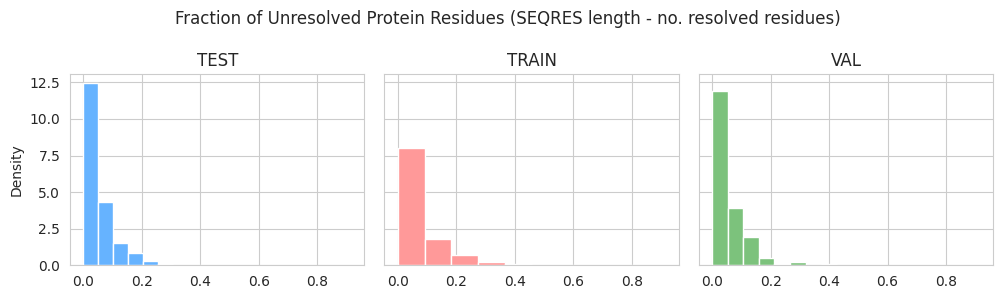

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharex=True, sharey=True)
grouped_data = plindex.drop_duplicates("system_id").groupby("split")
split_colors = {
    "train": "#ff9999",
    "test": "#66b3ff",
    "val": "#7cc27c",
}
for i, (split, data) in enumerate(grouped_data):
    data.system_protein_chains_fraction_unresolved_residues.hist(
        ax=axes[i], density=True, color=split_colors[split]
    )
    axes[i].set_title(split.upper())
    if i == 0:
        axes[i].set_ylabel("Density")
fig.suptitle(
    "Fraction of Unresolved Protein Residues (SEQRES length - no. resolved residues)"
)
plt.tight_layout()

In [29]:
print("Percentage of ligands with no unresolved heavy atoms:")
for split in ["train", "val", "test"]:
    print(
        f'{split.capitalize()}: {100 * (plindex[plindex["split"] == split].ligand_fraction_unresolved_heavy_atoms == 0).sum() / plindex[plindex["split"] == split].shape[0]:.2f}%'
    )

Percentage of ligands with no unresolved heavy atoms:
Train: 82.34%
Val: 90.75%
Test: 93.80%


### Pocket domains

We annotated domains from different databases onto the protein chains of each system and then picked the one spanning the pocket residues of the system as the domain of the system pocket.

In [30]:
pocket_domain_columns = column_descriptions[
    column_descriptions["Name"].str.startswith("system_pocket")
    & ~column_descriptions["Name"].str.startswith("system_pocket_validation")
]
pocket_domain_columns

,Name,Type,Description
377,system_pocket_CATH,str,CATH domain for the pocket
378,system_pocket_ECOD,str,ECOD domain for the pocket
379,system_pocket_ECOD_t_name,str,ECOD_t_name domain for the pocket
380,system_pocket_Pfam,str,Pfam domain for the pocket
381,system_pocket_SCOP2,str,SCOP2 domain for the pocket
382,system_pocket_SCOP2B,str,SCOP2B domain for the pocket
383,system_pocket_PANTHER,str,PANTHER domain for the pocket
384,system_pocket_UniProt,str,UniProt domain for the pocket
385,system_pocket_kinase_name,str,kinase_name domain for the pocket


In [31]:
plindex = query_index(
    columns=["system_id"] + list(pocket_domain_columns.Name),
)

In [32]:
plindex.drop_duplicates("system_id").system_pocket_ECOD_t_name.value_counts().head(10)

,count
system_pocket_ECOD_t_name,
Nucleoplasmin-like/VP (viral coat and capsid proteins),14051
P-loop containing nucleoside triphosphate hydrolases,13463
Protein kinase,11203
TIM barrels,9384
Immunoglobulin/Fibronectin type III/E set domains/PapD-like,9293
NAD(P)-binding Rossmann-fold domains,9213
Globin-like,7218
Ribosomal protein L31e/gp120 outer domain,7141
S2 subunit of coronavirus spike glycoprotein,6701


In [33]:
plindex.drop_duplicates("system_id").system_pocket_kinase_name.value_counts().head(10)

,count
system_pocket_kinase_name,
CDK2,494
p38a,413
EGFR,360
CK2a1,349
AurA,278
PIM1,211
ALK2,208
JAK2,191
IRAK4,186


### Ligand properties

Molecular properties and annotations are calculated from the ligand SMILES strings

In [34]:
properties = [
    "ligand_molecular_weight",
    "ligand_num_rot_bonds",
    "ligand_num_rings",
    "ligand_num_hbd",
    "ligand_num_hba",
    "ligand_num_heavy_atoms",
    "ligand_crippen_clogp",
    "ligand_qed",
    "ligand_tpsa",
    "ligand_is_kinase_inhibitor",
]
column_descriptions[column_descriptions["Name"].isin(properties)]

,Name,Type,Description
9,ligand_molecular_weight,float | None,Molecular weight
10,ligand_crippen_clogp,float | None,"Ligand Crippen MlogP, see https://www.rdkit.or..."
11,ligand_num_rot_bonds,int | None,Number of rotatable bonds
12,ligand_num_hbd,int | None,Number of hydrogen bond donors
13,ligand_num_hba,int | None,Number of hydrogen bond acceptors
14,ligand_num_rings,int | None,Number of rings
15,ligand_num_heavy_atoms,int | None,Number of heavy atoms
28,ligand_tpsa,float | None,Topological polar surface area
29,ligand_qed,float | None,"Ligand QED score, a measure of drug-likeness, ..."
52,ligand_is_kinase_inhibitor,bool,Check if ligand is a kinase inhibitor.


In [35]:
plindex = query_index(
    columns=["system_id", "ligand_instance_chain", "ligand_unique_ccd_code"]
    + properties,
    splits=["train", "val", "test"],
    filters=[
        ("ligand_is_proper", "==", True) # focusing on non-ion, non-artifact ligands
    ],
)
plindex.head(20)

,system_id,ligand_instance_chain,ligand_unique_ccd_code,ligand_molecular_weight,ligand_num_rot_bonds,ligand_num_rings,ligand_num_hbd,ligand_num_hba,ligand_num_heavy_atoms,ligand_crippen_clogp,ligand_qed,ligand_tpsa,ligand_is_kinase_inhibitor,split
0,3grt__1__1.A_2.A__1.B,1.B,FAD,785.157135,13,6,9,21,53,-2.42396,0.044261,362.93,False,train
1,3grt__1__1.A_2.A__1.C,1.C,TS2,721.288731,10,1,11,13,48,-4.04010,0.095714,313.27,False,train
2,3grt__1__1.A_2.A__2.B,2.B,FAD,785.157135,13,6,9,21,53,-2.42396,0.044261,362.93,False,train
3,3grt__1__1.A_2.A__2.C,2.C,TS2,721.288731,10,1,11,13,48,-4.04010,0.095714,313.27,False,train
4,1grx__1__1.A__1.B,1.B,GSH,307.083806,9,0,6,6,20,-2.20610,0.263437,158.82,True,train
5,6grf__1__1.A__1.D,1.D,HSR,221.089937,2,1,5,6,15,-3.07760,0.337239,119.25,False,train
6,6grf__2__1.B__1.E,1.E,HSR,221.089937,2,1,5,6,15,-3.07760,0.337239,119.25,False,train
7,3grj__2__1.B__1.I_1.L_1.Q,1.L,G14,188.058577,2,2,2,2,14,1.77490,0.754340,65.98,False,train
8,3grj__1__1.A__1.F,1.F,G14,188.058577,2,2,2,2,14,1.77490,0.754340,65.98,False,train
9,3grj__1__1.A__1.H,1.H,G14,188.058577,2,2,2,2,14,1.77490,0.754340,65.98,False,train


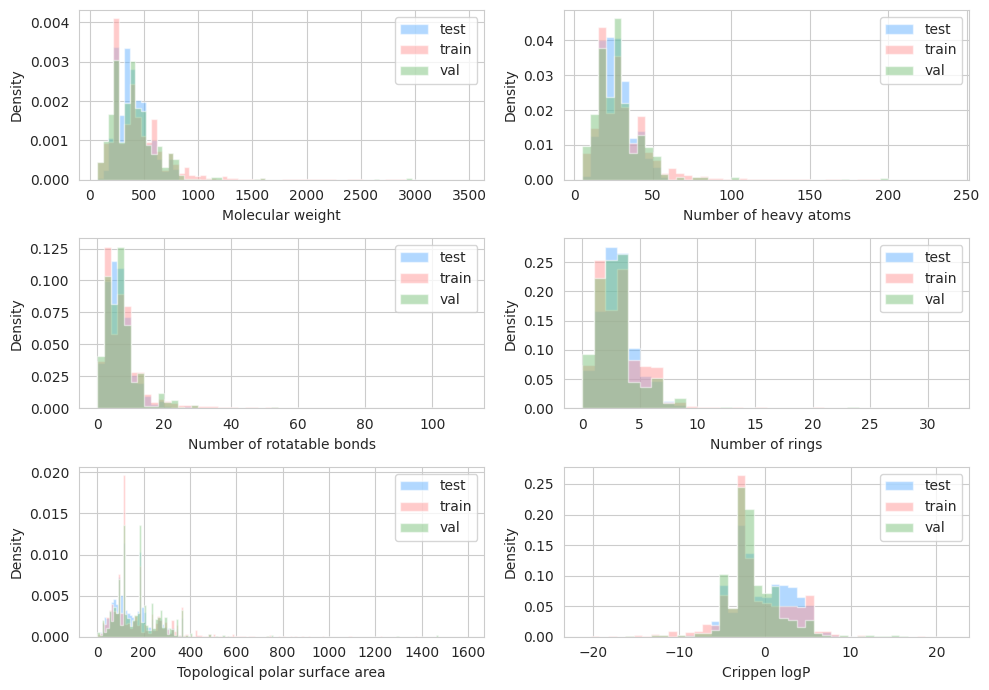

In [36]:
binwidths = {
    "ligand_molecular_weight": ("Molecular weight", 50),
    "ligand_num_heavy_atoms": ("Number of heavy atoms", 5),
    "ligand_num_rot_bonds": ("Number of rotatable bonds", 2),
    "ligand_num_rings": ("Number of rings", 1),
    "ligand_tpsa": ("Topological polar surface area", 10),
    "ligand_crippen_clogp": ("Crippen logP", 1),
}
fig, axes = plt.subplots(3, 2, figsize=(10, 7))
axes = axes.flatten()
for i, prop in enumerate(binwidths):
    ax = axes[i]
    plindex.groupby("split")[prop].plot(
        kind="hist",
        density=True,
        alpha=0.5,
        histtype="stepfilled",
        legend=True,
        ax=ax,
        color=split_colors,
        bins=np.arange(
            min(plindex[prop]),
            max(plindex[prop]) + binwidths[prop][1],
            binwidths[prop][1],
        ),
    )
    ax.set_xlabel(binwidths[prop][0])
    ax.set_ylabel("Density")
plt.tight_layout()
plt.show()

These properties were further used to categorize the ligands into different types.

In [37]:
ligand_types = [
    f"ligand_is_{x}"
    for x in [
        "lipinski",
        "covalent",
        "cofactor",
        "oligo",
        "ion",
        "fragment",
        "artifact",
    ]
]
column_descriptions[column_descriptions["Name"].isin(ligand_types)]

,Name,Type,Description
16,ligand_is_covalent,bool,Indicator of whether a ligand is a covalent l...
30,ligand_is_ion,bool,Indicator of whether a ligand is an ion
31,ligand_is_lipinski,bool,Indicator of whether a ligand satisfies Lipins...
32,ligand_is_fragment,bool,Indicator of whether a ligand satisfies fragme...
33,ligand_is_oligo,bool,Indicator of whether a ligand is an oligopept...
34,ligand_is_cofactor,bool,Indicator of whether a ligand is a cofactor
36,ligand_is_artifact,bool,Indicator of whether a ligand is an artifact


These categories were also aggregated to the system level for easier filtering:

In [38]:
column_descriptions[
    column_descriptions["Name"].isin(
        [n.replace("ligand_is", "system_ligand_has") for n in ligand_types]
    )
]

,Name,Type,Description
144,system_ligand_has_lipinski,bool,Whether the system has a lipinski ligand
145,system_ligand_has_cofactor,bool,Whether the system has a cofactor ligand
146,system_ligand_has_fragment,bool,Whether the system has a fragment ligand
147,system_ligand_has_oligo,bool,Whether the system has an oligomer ligand
148,system_ligand_has_artifact,bool,Whether the system has an artifact ligand
150,system_ligand_has_covalent,bool,Whether the system has a covalent ligand
152,system_ligand_has_ion,bool,Whether the system has an ion


In [39]:
plindex = query_index(
    columns=["system_id", "ligand_unique_ccd_code"] + ligand_types,
    splits=["train", "val", "test"],
)

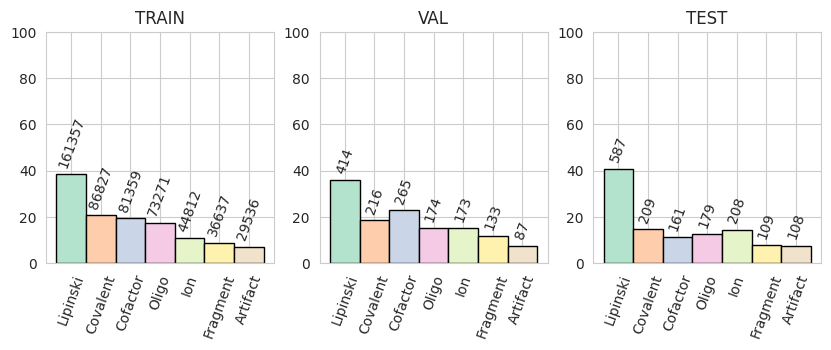

In [40]:
labels = [c.replace("ligand_is_", "").capitalize() for c in ligand_types]
bar_colors = plt.cm.Pastel2.colors
split_names = ["train", "val", "test"]
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
for i, split in enumerate(split_names):
    ax = axes[i]
    split_data = plindex[plindex["split"] == split]
    bars = ax.bar(
        labels,
        split_data[ligand_types].mean().mul(100).to_list(),
        width=1,
        color=bar_colors,
        edgecolor="black",
        label=split,
        linewidth=1,
    )
    ax.set_xticks(np.arange(len(labels)), labels, rotation=70)
    ax.set_ylim(0, 100)
    ax.set_title(split.upper())
    counts = split_data[ligand_types].sum().to_list()
    for bar, count in zip(bars, counts):
        ax.text(
            bar.get_x() + bar.get_width() / 2.0,
            bar.get_height() + 2,
            f"{count}",
            ha="center",
            va="bottom",
            rotation=70,
            fontsize=10,
        )

### PLI-specific properties

There are also some ligand properties that are specific to the interaction with the particular protein pocket present in the system. These include things like:
- The kinds of interactions the ligand may have with the protein, calculated using PLIP
- Experimental binding affinity, pulled from BindingDB when available
- Potential ligand-protein crystal contacts, defined as ligand-protein contacts below 5 Å which are not in the same asymmetric unit (symmetry mates) and not in the system biounit

In [41]:
pli_specific = [
    "system_fraction_atoms_with_crystal_contacts",
    "system_num_crystal_contacted_residues",
    "ligand_binding_affinity",
    "system_has_binding_affinity",
    "ligand_interactions",
    "system_num_interactions",
]
column_descriptions[column_descriptions["Name"].isin(pli_specific)]

,Name,Type,Description
53,ligand_binding_affinity,float | None,Binding affinity (pKd or pKi) from BindingDB w...
60,system_num_interactions,int,Number of interactions of the system
69,system_has_binding_affinity,bool,Whether any ligand in the system has a binding...
74,system_num_crystal_contacted_residues,int,Number of residues from other symmetry mates w...
82,system_fraction_atoms_with_crystal_contacts,float | None,Fraction of atoms in the system ligands which ...
158,ligand_interactions,list[str],Interactions of the ligand


In [42]:
plindex = query_index(
    columns=["system_id"] + pli_specific,
    splits=["train", "val", "test"],
)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

You could filter out systems with crystal contacts:

In [43]:
(
    plindex.drop_duplicates("system_id").system_fraction_atoms_with_crystal_contacts > 0
).sum()

34467

If your model has an additional component for predicting binding affinity, you could see how much data is available for training and evaluation:

In [44]:
plindex.drop_duplicates("system_id").groupby(
    "split"
).system_has_binding_affinity.value_counts()

split  system_has_binding_affinity
test   False                             862
       True                              174
train  False                          261204
       True                            47936
val    False                             685
       True                              147
Name: count, dtype: int64

Text(0, 0.5, 'No. of system ligands')

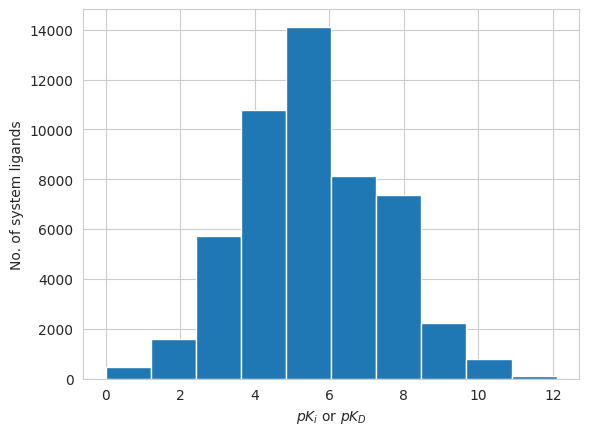

In [45]:
plindex["ligand_binding_affinity"].hist()
plt.xlabel(r"$pK_i$ or $pK_D$")
plt.ylabel("No. of system ligands")

You could even look deeper into the kinds of protein-ligand interactions present in your training data:

In [46]:
plindex.groupby("split").system_num_interactions.describe()

,count,mean,std,min,25%,50%,75%,max
split,,,,,,,,
test,1436.0,16.591226,9.886007,3.0,9.0,15.0,22.0,51.0
train,418381.0,14.448139,12.087511,0.0,5.0,12.0,21.0,722.0
val,1157.0,16.078652,10.204647,0.0,8.0,14.0,22.0,49.0


In [47]:
plindex["ligand_interactions"].values[0]

array(['1.A_36_type:hydrogen_bonds__protisdon:False__sidechain:False',
       '1.A_113_type:hydrogen_bonds__protisdon:False__sidechain:False',
       '1.A_113_type:hydrogen_bonds__protisdon:True__sidechain:False',
       '1.A_312_type:hydrogen_bonds__protisdon:False__sidechain:False',
       '1.A_320_type:hydrogen_bonds__protisdon:False__sidechain:False',
       '1.A_322_type:hydrogen_bonds__protisdon:False__sidechain:True',
       '1.A_322_type:hydrogen_bonds__protisdon:True__sidechain:False',
       '1.A_40_type:hydrogen_bonds__protisdon:True__sidechain:False',
       '1.A_40_type:hydrophobic_contacts',
       '1.A_13_type:hydrogen_bonds__protisdon:True__sidechain:False',
       '1.A_13_type:hydrogen_bonds__protisdon:True__sidechain:True',
       '1.A_11_type:hydrogen_bonds__protisdon:True__sidechain:False',
       '1.A_35_type:hydrogen_bonds__protisdon:True__sidechain:True',
       '1.A_34_type:hydrogen_bonds__protisdon:True__sidechain:False',
       '1.A_49_type:hydrogen_bonds__pro

## Beyond the split (optional)

Here we mainly focused on systems in the train/val/test splits as the train and val splits are the ones that can be used for training models to either participate in the PLINDER leaderboard or compare your models' performance to methods in the leaderboard.

However, PLINDER itself contains all PLI systems in the PDB (except those containing only crystallization artifacts), and you may be interested in this dataset as a whole. This can be queried with the `splits=["*"]` option.

In [48]:
plindex = query_index(
    columns=[
        "system_id",
        "entry_pdb_id",
        "system_num_protein_chains",
        "system_num_ligand_chains",
    ]
    + ligand_types,
    splits=["*"],
)
print("No. ligands:", len(plindex))
print("No. systems:", plindex.system_id.nunique())
print("No. PDB entries:", plindex.entry_pdb_id.nunique())

No. ligands: 1357906
No. systems: 990260
No. PDB entries: 143800


system_num_protein_chains
1     857629
2     312129
3      73237
4      19875
30     14122
       ...  
72        72
64        64
53        61
52        52
29        30
Name: count, Length: 74, dtype: int64
system_num_ligand_chains
1     809509
2     248916
3     107613
4      45856
5      17065
       ...  
84        84
39        78
74        74
67        67
46        46
Name: count, Length: 238, dtype: int64


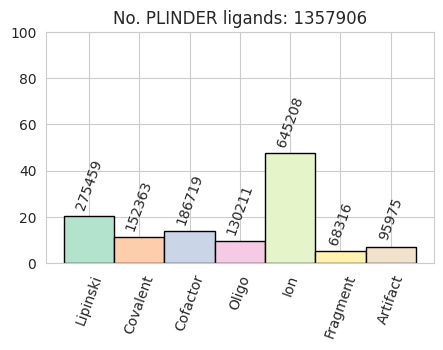

In [ ]:
fig, ax = plt.subplots(figsize=(5, 3))
bars = ax.bar(
    labels,
    plindex[ligand_types].mean().mul(100).to_list(),
    width=1,
    color=bar_colors,
    edgecolor="black",
    label=split,
    linewidth=1,
)
ax.set_xticks(np.arange(len(labels)), labels, rotation=70)
ax.set_ylim(0, 100)
ax.set_title(f"No. PLINDER ligands: {len(plindex)}")
counts = plindex[ligand_types].sum().to_list()
for bar, count in zip(bars, counts):
    ax.text(
        bar.get_x() + bar.get_width() / 2.0,
        bar.get_height() + 2,
        f"{count}",
        ha="center",
        va="bottom",
        rotation=70,
        fontsize=10,
    )

print(plindex.system_num_protein_chains.value_counts())
print(plindex.system_num_ligand_chains.value_counts())

When looking at distributions across the entire dataset, you'll notice that there are quite a lot of ion systems, as well as systems with more than 5 protein or ligand chains.

**NOTE: _While we provide annotations for all systems, those which are not in the train and val splits may not be used for training models to participate in the MLSB PLINDER leaderboard._**

## Similarity clusters

Similarity between two protein-ligand complexes can occur at various levels, including protein sequence, structural features, binding pocket characteristics, or ligand and interaction properties. We calculated a comprehensive set of similarity metrics to cover every combination of these dimensions — from identical systems, where the protein, pocket, interactions and ligand are the same, to systems that differ across all levels.

The entire set of similarity metrics is described [here](https://plinder-org.github.io/plinder/dataset.html#clusters-clusters), and they were calculated across all pairs of systems having a Foldseek or MMseqs alignment. We then used graph clustering to group systems into clusters based on their similarity with a specific **_metric_** and **_threshold_**. There are three types of clusters available: strongly connected graph components (**_strong component_**), weakly connected graph components (**_weak component_**), and communities detected using asynchronous label propagation (**_community_**).

We can load the similarity clusters assigned to each system for different metrics, thresholds, and clustering types.

In [49]:
column_descriptions[
    column_descriptions["Name"].str.startswith("pocket_")
    & column_descriptions["Name"].str.contains("community")
]

,Name,Type,Description
601,pocket_fident__50__community,str,Cluster ID for community built from pocket_fid...
602,pocket_fident__70__community,str,Cluster ID for community built from pocket_fid...
603,pocket_fident__95__community,str,Cluster ID for community built from pocket_fid...
604,pocket_fident__100__community,str,Cluster ID for community built from pocket_fid...
605,pocket_fident_qcov__50__community,str,Cluster ID for community built from pocket_fid...
606,pocket_fident_qcov__70__community,str,Cluster ID for community built from pocket_fid...
607,pocket_fident_qcov__95__community,str,Cluster ID for community built from pocket_fid...
608,pocket_fident_qcov__100__community,str,Cluster ID for community built from pocket_fid...
609,pocket_lddt__50__community,str,Cluster ID for community built from pocket_ldd...
610,pocket_lddt__70__community,str,Cluster ID for community built from pocket_ldd...


In [50]:
column_descriptions[
    column_descriptions["Name"].str.startswith("pocket_lddt")
    & column_descriptions["Name"].str.contains("component")
]

,Name,Type,Description
420,pocket_lddt__50__weak__component,str,Cluster ID for weak component built from pocke...
421,pocket_lddt__70__weak__component,str,Cluster ID for weak component built from pocke...
422,pocket_lddt__95__weak__component,str,Cluster ID for weak component built from pocke...
423,pocket_lddt__100__weak__component,str,Cluster ID for weak component built from pocke...
424,pocket_lddt__50__strong__component,str,Cluster ID for strong component built from poc...
425,pocket_lddt__70__strong__component,str,Cluster ID for strong component built from poc...
426,pocket_lddt__95__strong__component,str,Cluster ID for strong component built from poc...
427,pocket_lddt__100__strong__component,str,Cluster ID for strong component built from poc...
428,pocket_lddt_qcov__50__weak__component,str,Cluster ID for weak component built from pocke...
429,pocket_lddt_qcov__70__weak__component,str,Cluster ID for weak component built from pocke...


These cluster labels can be used in many ways with the annotations.

### Example: ATP-binding pockets (optional)

For example, maybe you are interested in seeing how many different kinds of ATP-binding pockets we have. First, let's find all the analogs of ATP. We can do this by finding the 95% ECFP4 tanimoto similarity component of ATP and then getting the CCD codes of all the ligands in the same cluster:

In [51]:
ligand_cluster_column = "tanimoto_similarity_max__95__strong__component"
atp_ligand_cluster = query_index(
    columns=[
        ligand_cluster_column,
    ],
    filters=[
        ("ligand_unique_ccd_code", "==", "ATP"),
        ("system_num_ligand_chains", "==", 1),
    ],
)[ligand_cluster_column].values[0]

atp_analogs = (
    query_index(
        columns=["system_id", "entry_pdb_id", "ligand_unique_ccd_code", "ligand_rdkit_canonical_smiles"],
        filters=[
            (ligand_cluster_column, "==", atp_ligand_cluster),
            ("system_num_ligand_chains", "==", 1),
        ],
    ).drop_duplicates("ligand_unique_ccd_code")
)
atp_analogs_code_set = set(atp_analogs.ligand_unique_ccd_code.unique())
atp_analogs_code_set

{'5FA', 'ADP', 'AQP', 'ATP', 'ZF9', 'ZSF'}

Let's see how they look

In [52]:
import mols2grid
grid = mols2grid.MolGrid(atp_analogs, smiles_col='ligand_rdkit_canonical_smiles')
grid.display(subset=["ligand_unique_ccd_code","img"])

MolGridWidget()

Now we can get the pocket clusters of all systems containing ATP analogs. Here we're using `pocket_qcov__50__weak__component`, meaning a system within a cluster has some other system in that cluster with which it shares at least 50% of pocket residues when aligned.

In [53]:
pocket_cluster_column = "pocket_qcov__50__weak__component"
plindex = query_index(
    columns=[
        "system_id",
        "entry_pdb_id",
        "entry_release_date",
        pocket_cluster_column,
        "system_pocket_ECOD_t_name",
    ],
    filters=[
        ("ligand_unique_ccd_code", "in", atp_analogs_code_set),  # only ATP-binding systems
        ("ligand_num_interactions", ">", 2),  # with >2 interactions with ATP
        ("system_num_ligand_chains", "==", 1),  # and ATP is the only ligand
    ],
)

In [54]:
(
    "No. systems:", plindex.system_id.nunique(),
    "No. PDB entries:", plindex.entry_pdb_id.nunique(),
    "No. clusters:", plindex[pocket_cluster_column].nunique(),
)

('No. systems:', 5409, 'No. PDB entries:', 1484, 'No. clusters:', 154)

In [55]:
plindex[pocket_cluster_column].value_counts().head(10)

,count
pocket_qcov__50__weak__component,
c0,3562
c123,260
c11,259
c206,146
c204,141
c132,80
c391,75
c95,73
c205,58


When we look at the ECOD topology names of the cluster "c11" for example, we see that these systems are GroEL equatorial domain-like domains. Interestingly, 7 systems from 2 different PDB entries don't have ECOD annotations yet as they were recently released, but are indeed [the same domain](https://doi.org/10.1038/s41467-024-45242-x).

In [56]:
plindex[plindex[pocket_cluster_column] == "c11"].system_pocket_ECOD_t_name.value_counts(
    dropna=False
)

,count
system_pocket_ECOD_t_name,
GroEL equatorial domain-like,252
None,7


In [57]:
plindex[
    (plindex[pocket_cluster_column] == "c11")
    & (plindex["system_pocket_ECOD_t_name"].isna())
].drop_duplicates("entry_pdb_id")

,system_id,entry_pdb_id,entry_release_date,pocket_qcov__50__weak__component,system_pocket_ECOD_t_name,split
527,8i6j__1__1.B__1.C,8i6j,2023-01-28,c11,None,train
2756,8hki__1__1.I__1.Q,8hki,2022-11-27,c11,None,train


In [58]:
plindex[plindex["system_pocket_ECOD_t_name"].isna()]["entry_pdb_id"].nunique()

290

### Example: Diversity sampling (optional)

The `pli_unique_qcov__50__community` column clusters systems such that the protein and ligand make similar interactions with the pocket. This clustering combines protein sequence and structural similarity (needed to obtain the pocket alignment), as well as the ligand-pocket interactions, making it a good proxy for unique kinds of binding present in the dataset.

Here's an example of how one might use `torch.utils.data.WeightedRandomSampler` to sample training systems based on their PLI community cluster.

In [59]:
from torch.utils.data import WeightedRandomSampler

cluster_column = "pli_unique_qcov__50__community"

# Get train systems and their cluster labels
plindex = query_index(
    columns=["system_id", "entry_pdb_id", cluster_column], splits=["train"]
).drop_duplicates("system_id")

# Add the number of systems in each cluster to the dataframe
plindex = plindex.merge(
    plindex[cluster_column].value_counts().rename("cluster_num_systems"),
    left_on=cluster_column,
    right_index=True,
).reset_index(drop=True)

# Add the number of PDB entries in each cluster to the dataframe
plindex = plindex.merge(
    plindex.drop_duplicates("entry_pdb_id")[cluster_column]
    .value_counts()
    .rename("cluster_num_entries"),
    left_on=cluster_column,
    right_index=True,
).reset_index(drop=True)

# Ignore clusters with only one PDB entry
sample_from = plindex[plindex["cluster_num_entries"] > 1].reset_index(drop=True)

# Calculate the weight for each cluster
cluster_weights = 1.0 / sample_from.cluster_num_systems.values

# Create a WeightedRandomSampler and sample systems from the train set
sampler = WeightedRandomSampler(
    weights=cluster_weights, num_samples=len(cluster_weights)
)
sampled_indices = list(sampler)
sampled_plindex = (
    sample_from.iloc[sampled_indices]
    .reset_index(drop=True)
    .drop(columns=["cluster_num_systems", "cluster_num_entries"])
)

# Add the number of sampled systems in each cluster to the sampled dataframe
sampled_plindex = sampled_plindex.merge(
    sampled_plindex[cluster_column].value_counts().rename("cluster_num_systems"),
    left_on=cluster_column,
    right_index=True,
).reset_index(drop=True)

# Add the number of sampled PDB entries in each cluster to the sampled dataframe
sampled_plindex = (
    sampled_plindex.merge(
        sampled_plindex.drop_duplicates("entry_pdb_id")[cluster_column]
        .value_counts()
        .rename("cluster_num_entries"),
        left_on=cluster_column,
        right_index=True,
    )
)

In [60]:
print("No. of original systems: ", sample_from.system_id.nunique())
print("No. of nonredundant sampled systems: ", sampled_plindex.system_id.nunique())
print("No. of original clusters: ", sample_from[cluster_column].nunique())
print("No. of sampled clusters: ", sampled_plindex[cluster_column].nunique())

No. of original systems:  259772
No. of nonredundant sampled systems:  57298
No. of original clusters:  2723
No. of sampled clusters:  2721


Let's see how the sampling process has affected the distribution of cluster sizes.

Text(0, 0.5, '# Clusters')

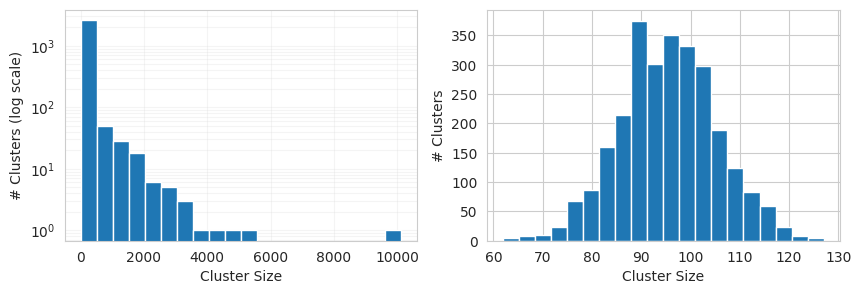

In [61]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))

cluster_sizes = (
    sample_from.drop_duplicates(cluster_column)
    .cluster_num_systems.value_counts()
    .sort_index()
)
ax[0].hist(cluster_sizes.index, weights=cluster_sizes.values, bins=20, log=True)
ax[0].set_xlabel("Cluster Size")
ax[0].set_ylabel("# Clusters (log scale)")
ax[0].grid(True, which="both", ls="-", alpha=0.2)

cluster_sizes = (
    sampled_plindex.drop_duplicates(cluster_column)
    .cluster_num_systems.value_counts()
    .sort_index()
)
ax[1].hist(cluster_sizes.index, weights=cluster_sizes.values, bins=20, log=False)
ax[1].set_xlabel("Cluster Size")
ax[1].set_ylabel("# Clusters")

## Beyond the PLINDEX (optional)

Not everything we annotated made it into the index file, as we tried to compromise between accessibility and usability. Here's how to get some more data from the additional files that are part of the dataset.

### Annotation JSON files

With `plinder.core.index.utils.load_entries` you can load the JSON file of a particular PDB ID and access all the information we extracted and saved for that ID.



In [ ]:
from plinder.core.index.utils import load_entries

In [ ]:
entries = load_entries(pdb_ids=["4agi"])

In [ ]:
entries["4agi"].keys()

dict_keys(['pdb_id', 'release_date', 'oligomeric_state', 'determination_method', 'keywords', 'pH', 'resolution', 'chains', 'ligand_like_chains', 'systems', 'covalent_bonds', 'chain_to_seqres', 'validation', 'pass_criteria', 'water_chains', 'symmetry_mate_contacts'])

In [ ]:
entries["4agi"]["systems"]["4agi__1__1.C__1.W"].keys()

dict_keys(['pdb_id', 'biounit_id', 'ligands', 'ligand_validation', 'pocket_validation', 'pass_criteria'])

In [ ]:
entries["4agi"]["systems"]["4agi__1__1.C__1.W"]["ligands"][0].keys()

dict_keys(['pdb_id', 'biounit_id', 'asym_id', 'instance', 'ccd_code', 'plip_type', 'bird_id', 'centroid', 'smiles', 'resolved_smiles', 'residue_numbers', 'rdkit_canonical_smiles', 'molecular_weight', 'crippen_clogp', 'num_rot_bonds', 'num_hbd', 'num_hba', 'num_rings', 'num_heavy_atoms', 'is_covalent', 'covalent_linkages', 'neighboring_residues', 'neighboring_ligands', 'interacting_residues', 'interacting_ligands', 'interactions', 'neighboring_residue_threshold', 'neighboring_ligand_threshold', 'num_neighboring_ppi_atoms_within_4A_of_gap', 'num_neighboring_ppi_atoms_within_8A_of_gap', 'num_missing_ppi_interface_residues', 'num_pli_atoms_within_4A_of_gap', 'num_pli_atoms_within_8A_of_gap', 'num_missing_pli_interface_residues', 'num_resolved_heavy_atoms', 'num_unresolved_heavy_atoms', 'tpsa', 'qed', 'is_ion', 'is_lipinski', 'is_fragment', 'is_oligo', 'is_cofactor', 'in_artifact_list', 'is_artifact', 'is_other', 'is_invalid', 'posebusters_result', 'unique_ccd_code', 'waters', 'crystal_cont

### Annotation PyDantic classes

With `plinder.data.pipeline.utils.load_entries_from_zips` you can reconstruct the PyDantic dataclasses of the `Entry`, `System` and `Ligand`s to get access to more properties (though this requires a developer install of plinder with more dependencies)

In [ ]:
from plinder.data.pipeline.utils import load_entries_from_zips
from pathlib import Path

entries = load_entries_from_zips(data_dir=Path(cfg.data.plinder_dir), pdb_ids=["4agi"])

In [ ]:
import pandas as pd

In [ ]:
rows = []
for name, (description, ftype) in entries["4agi"].get_descriptions_and_types().items():
  rows.append((name, description, ftype))
pd.DataFrame(rows, columns=["Name", "Description", "Type"])

,Name,Description,Type
0,pdb_id,RCSB PDB ID. See https://mmcif.wwpdb.org/dicti...,str
1,release_date,RCSB structure release date. See https://mmcif...,str
2,oligomeric_state,Author's provided description of quaternary st...,str | None
3,determination_method,RCSB method of structure determination. See ht...,str | None
4,keywords,RCSB keywords describing the structure. See ht...,str | None
5,pH,pH at which structure is solved. See https://m...,str | None
6,resolution,RCSB structure resolution. See https://mmcif.w...,float | None
7,chains,__Chains dictionary with chain name mapped to ...,"dict[str, Chain]"
8,ligand_like_chains,__Chain: chain type for other ligand-like chai...,"dict[str, str]"
9,systems,__System dictionary with system id mapped to s...,"dict[str, System]"


In [ ]:
entries["4agi"].validation

EntryValidation(resolution=1.6, rfree=0.19, r=0.15, clashscore=1.17, percent_rama_outliers=0.32, percent_rota_outliers=1.23, data_completeness=95.72, percent_RSRZ_outliers=0.0, atom_count=11266, molprobity=0.8983484492741365, mean_b_factor=12.817485613528603, median_b_factor=10.989999771118164, pdbx_resolution=1.6, pdbx_reflns_resolution=1.6, meanI_over_sigI_obs=4.1, r_minus_rfree=0.04000000000000001)

In [ ]:
rows = []
for name, (description, ftype) in entries["4agi"].systems["4agi__1__1.C__1.W"].get_descriptions_and_types().items():
  rows.append((name, description, ftype))
pd.DataFrame(rows, columns=["Name", "Description", "Type"])

,Name,Description,Type
0,pdb_id,__PDB ID,str
1,biounit_id,Biounit ID,str
2,ligands,__List of Ligands in a systems,list[Ligand]
3,ligand_validation,__Validation object for the ligand residues in...,ResidueListValidation | None
4,pocket_validation,__Validation object for the system's pocket re...,ResidueListValidation | None
5,pass_criteria,__Passes quality criteria,bool | None
6,protein_chains_asym_id,\n Interacting protein chains of the sy...,list[str]
7,id_no_biounit,\n ID of the system without the biounit...,str
8,ligand_chains,\n Ligand chains of the system\n,list[str]
9,num_pocket_residues,\n Number of pocket residues of the sys...,int


In [ ]:
rows = []
for name, (description, ftype) in entries["4agi"].systems["4agi__1__1.C__1.W"].ligands[0].get_descriptions_and_types().items():
  rows.append((name, description, ftype))
pd.DataFrame(rows, columns=["Name", "Description", "Type"])

,Name,Description,Type
0,pdb_id,"__RCSB PDB ID, see https://mmcif.wwpdb.org/dic...",str
1,biounit_id,__Biounit id,str
2,asym_id,Ligand chain asymmetric id,str
3,instance,Biounit instance ID,int
4,ccd_code,Ligand Chemical Component Dictionary (CCD) code,str
...,...,...,...
63,id,\n Unique identifier for a given ligand...,str
64,instance_chain,\n Instance chain for a given ligand.\n...,str
65,interactions_counter,\n __Counter of interactions for a give...,"dict[str, dict[int, ty.Counter[str]]]"
66,is_kinase_inhibitor,\n Check if ligand is a kinase inhibito...,bool


In [ ]:
entries["4agi"].systems["4agi__1__1.C__1.W"].pocket_residues

defaultdict(dict,
            {'1.C': {22: 'interacting',
              23: 'neighboring',
              24: 'interacting',
              40: 'interacting',
              44: 'interacting',
              271: 'neighboring',
              280: 'neighboring',
              282: 'interacting',
              284: 'neighboring',
              296: 'interacting',
              298: 'neighboring',
              300: 'neighboring',
              308: 'neighboring',
              309: 'interacting'}})

In [ ]:
entries["4agi"].systems["4agi__1__1.C__1.W"].ligands[0].interactions

{'1.C': {296: ['type:hydrogen_bonds__protisdon:False__sidechain:True'],
  309: ['type:hydrogen_bonds__protisdon:True__sidechain:False'],
  282: ['type:hydrogen_bonds__protisdon:True__sidechain:True'],
  22: ['type:hydrophobic_contacts', 'type:water_bridges__protisdon:True'],
  24: ['type:hydrophobic_contacts'],
  40: ['type:hydrophobic_contacts'],
  44: ['type:water_bridges__protisdon:False']}}

In [ ]:
entries["4agi"].chains["C"].residues[22]

Residue(chain='C', index=20, number=22, auth_number='22', one_letter_code='N', name='ASN', chem_type='A', validation=ResidueValidation(altcode='.', inscode='?', rsr=0.074, rsrz=-0.48, rscc=0.957, average_occupancy=1.0, average_b_factor=13.938749999999999, unknown_residue=False, atom_count=8, unknown_atom_count=0, heavy_atom_count=8, num_unresolved_heavy_atoms=0, is_outlier={'geometry': False, 'density': False, 'chirality': False, 'clashes': False}, is_atom_count_consistent=True, has_clashing_partial_occupancy_atoms=False, alt_count=1))

### Similarity scores



If you want more direct similarities between systems than the provided cluster labels, we also provide the entire set of calculated similarity scores, in three kinds of similarity datasets:
- Similarity between ligand bound systems (`holo`)
- Similarity between holo systems and unbound protein structures (`apo`) where "unbound" can also include only ion-bound and only artifact-bound.
- Similarity between holo systems and Alphafold predicted structures (`pred`) where the search was performed on all AFDB models having a UniProt ID present in any of the holo systems.

Any of these could be specified in `query_protein_similarity()`

**NOTE: _The "holo" search database takes 68G of disk space and, depending on the metric, threshold and filters used, can take up to a terabyte of RAM to query._**

The `apo` and `pred` search databases on the other hand are the result of a Foldseek + MMseqs search with a very strict coverage and identity threshold of 0.9. Thus, they are much smaller and lighter to query, and do not contain very sensitive or remote similarities. We'll see an example of querying these later on.

Here is an example of using the `query_protein_similarity` function to get the similarities > 50 between a "train" set and a "test" set for the `pli_unique_qcov` metric

```python
# Example train systems
train = ["7jxf__1__1.A_1.B__1.G", "1jtu__1__1.A_1.B__1.C_1.D",
         "8f9d__2__1.C_1.D__1.G", "6a9a__1__1.A_2.A__2.C_2.D",
         "1b5e__2__1.A_1.B__1.D"]
# Example test systems
test = ["1b5d__1__1.A_1.B__1.D", "1s2g__1__1.A_2.C__1.D",
       "4agi__1__1.C__1.W", "4n7m__1__1.A_1.B__1.C",
         "7eek__1__1.A__1.I"]

metric = "pli_unique_qcov"
threshold = 50
query_protein_similarity(
        search_db="holo",
        columns=["query_system", "target_system", "similarity"],
        filters=[
                ("query_system", "in", test),
                ("target_system", "in", train),
                ("metric", "==", metric),
                ("similarity", ">=", threshold),
            ],
)
```

For ligand similarities, one can use the following approach:

In [ ]:
from plinder.core.scores import query_index

plindex = query_index(columns=["system_id", "ligand_rdkit_canonical_smiles"], splits=["val"])

In [ ]:
# Example test and train

test = set(plindex.system_id.values[:10])
train = set(plindex.system_id.values[20:50])

In [ ]:
from plinder.data import smallmolecules

plindex["fp"] = plindex["ligand_rdkit_canonical_smiles"].map(smallmolecules.mol2morgan_fp)
test_set = plindex.loc[plindex["system_id"].isin(test)].reset_index(drop=True)
test_set["tanimoto_similarity_max"] = smallmolecules.tanimoto_maxsim_matrix(
    plindex.loc[plindex["system_id"].isin(train)]["fp"].to_list(),
    test_set["fp"].to_list(),
)

In [ ]:
test_set["tanimoto_similarity_max"]

,tanimoto_similarity_max
0,14.285714
1,100.000000
2,0.000000
3,81.355932
4,100.000000
5,85.714286
6,98.214286
7,14.285714
8,0.000000
9,13.559322


# Accessing system files



We provide files for all holo PLINDER systems with <6 protein and <6 ligand chains. These can be accessed with the `PlinderSystem` object which also does the work of downloading and extracting only the relevant files.

In [62]:
from plinder.core import PlinderSystem

plinder_system = PlinderSystem(system_id="4agi__1__1.C__1.W")

We can visualise the system using py3Dmol

In [70]:
view = py3Dmol.view()
view.setBackgroundColor('white')

view.addModel(open(plinder_system.system_cif, 'r').read(),'cif')
view.setStyle({'chain':"1.C"}, {'cartoon': {'color':'purple'}})
view.setStyle({'chain':"1.W"}, {'stick': {'colorScheme':'elem'}})

view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

### Ligand

The ligands are provided in SDF format in `ligand_sdfs`.


In [ ]:
plinder_system.ligand_sdfs

{'1.W': '/content/plinder/2024-06/v2/systems/4agi__1__1.C__1.W/ligand_files/1.W.sdf'}

And the corresponding SMILES strings in `smiles`.

In [ ]:
plinder_system.smiles

{'1.W': 'C[Se][C@@H]1O[C@@H](C)[C@@H](O)[C@@H](O)[C@@H]1O'}

### Receptor

The CIF/PDB files of the receptor are stored in `receptor_cif` and `receptor_pdb` and only contain the protein chains of the system.

In [ ]:
plinder_system.receptor_pdb, plinder_system.receptor_cif

('/content/plinder/2024-06/v2/systems/4agi__1__1.C__1.W/receptor.pdb',
 '/content/plinder/2024-06/v2/systems/4agi__1__1.C__1.W/receptor.cif')

We recommend using the CIF file as PDB is an obsoleted format. However, if you must use the PDB file, an additional consideration is that the chains are renamed to single letters, which you can access with the `chain_mapping` attribute.


In [ ]:
plinder_system.chain_mapping

{'1.C': 'A'}

The FASTA file and sequences of the receptor are stored in `sequences_fasta` and `sequences` respectively. These are the canonical sequences of all protein chains in the system.


In [ ]:
plinder_system.sequences_fasta, plinder_system.sequences

('/content/plinder/2024-06/v2/systems/4agi__1__1.C__1.W/sequences.fasta',
 {'1.C': 'MSTPGAQQVLFRTGIAAVNSTNHLRVYFQDVYGSIRESLYEGSWANGTEKNVIGNAKLGSPVAATSKELKHIRVYTLTEGNTLQEFAYDSGTGWYNGGLGGAKFQVAPYSXIAAVFLAGTDALQLRIYAQKPDNTIQEYMWNGDGWKEGTNLGGALPGTGIGATSFRYTDYNGPSIRIWFQTDDLKLVQRAYDPHKGWYPDLVTIFDRAPPRTAIAATSFGAGNSSIYMRIYFVNSDNTIWQVCWDHGKGYHDKGTITPVIQGSEVAIISWGSFANNGPDLRLYFQNGTYISAVSEWVWNRAHGSQLGRSALPPA'})

### Linked structures

Where possible, we've linked plinder systems to associated apo structures from the PDB and predicted structures from AFDB. This was done using the same kind of similarity searches used for system clustering except with strict restrictions on the sequence identity and coverage of linked structures.

The `linked_structures` attribute is a pandas DataFrame with information on the links for a system which were both found and additionally scored for conformational difficulty. This additional scoring consists of superposing the found apo or predicted chain to the receptor of the system with global sequence-based alignment, transplanting the ligand to the found structure, and evaluating the resulting protein-ligand complex as though it were a predicted structure for the given system. So, the `linked_structures` DataFrame contains the similarity scores from the alignments as well as the metrics from the evaluation.

In [ ]:
link_info = plinder_system.linked_structures

In [ ]:
link_info[
    [
        "id",
        "pocket_fident",
        "lddt",
        "bb_lddt",
        "lddt_lp_ave",
        "lddt_pli_ave", # TODO: rename lddt_pli_amd_ave to this
        "scrmsd_ave", # TODO: replace with bisy_rmsd_ave
        "sort_score",
        "kind",
    ]
]

,id,pocket_fident,lddt,bb_lddt,lddt_lp_ave,lddt_pli_ave,scrmsd_ave,sort_score,kind
0,4uou_B,100.0,0.972682,0.994065,0.987813,0.989623,0.159702,2.40,apo
1,4uou_C,100.0,0.973562,0.994687,0.967287,0.971698,0.194233,2.40,apo
2,4uou_D,100.0,0.973604,0.994235,0.972579,0.973585,0.101252,2.40,apo
3,4uou_A,100.0,0.967257,0.994800,0.976908,0.963208,0.214243,2.40,apo
4,Q4WW81_A,100.0,0.982275,0.998587,0.999679,0.997170,0.126228,98.57,pred


For example, here we can see that "4uou_B"
- has 100% identical residues corresponding to the pocket of the system
- has a very high lDDT and backbone lDDT scores, indicating that the structure is very similar to the receptor.
- has a `sort_score` of 2.4, which is the resolution for an apo structure and the plDDT score for a predicted structure.

Indeed the superposition + transplant results show the same story
- a global superposition puts the ligand in the right place (seen by the `bisy_rmsd` of the ligand pose),
- the distances between the pocket atoms are similar (seen by the `lddt_lp_ave` metric),
- and the distances between the ligand and protein atoms are similar (seen by the `lddt_pli_ave` metric).

`get_linked_structure` then gives the file path to the found structure

NOTE: if you have not previously downloaded the dataset, the below command may take a couple of minutes to downloaded the relevant files

In [ ]:
plinder_system.get_linked_structure("apo", "4uou_B")

'/content/plinder/2024-06/v2/linked_structures/4uou_B.cif'

### Linking more structures (optional)

We attempted to link all single protein chain holo systems to up to 5 apo structures and up to 5 predicted structures and additionally evaluated these links for conformational difficulty.

All of these can be accessed with `query_links`

In [ ]:
from plinder.core.scores import query_index, query_links

In [ ]:
plindex = query_index(
    filters=[
        ("system_num_protein_chains", "==", 1),
    ]
)

In [ ]:
all_scored_links = query_links(
    filters=[("reference_system_id", "in", set(plindex.system_id))]
)
(
    len(all_scored_links),
    all_scored_links.reference_system_id.nunique(),
    all_scored_links.id.nunique(),
)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

(418050, 106498, 28728)

In [ ]:
plindex["has_scored_linked_structure"] = plindex.system_id.isin(
    all_scored_links.reference_system_id
)

In [ ]:
plindex.drop_duplicates("system_id").groupby(
    "split"
).has_scored_linked_structure.value_counts()

split  has_scored_linked_structure
train  True                           106128
       False                           91631
val    True                              370
       False                             157
Name: count, dtype: int64

This is not complete coverage across the entire training set however, and has a number of caveats:
- _apo_ structures could not be found for all systems
- AFDB does not contain predicted structures for viral proteins
- We did not attempt to link multi-protein holo systems
- We only scored up to 5 links per system for performance reasons, sorting by resolution for apo and plDDT for predicted links
- Not all links have 100% identical pocket residues as we used a threshold of 95%
- Coverage was only checked for the system receptor (>80%) meaning the linked structure may be much longer


You may want to have more links per system, more 100% identical pocket links, or additionally have cross-docking structures as links. You can query the `apo`, `pred` (and `holo` but don't run that in Colab!) search scores directly to get such results, using the `multi_query_protein_similarity` function, which returns hits matching all given criteria:

In [ ]:
from plinder.core.scores.protein import multi_query_protein_similarity

In [ ]:
filter_criteria: dict[str, int] = {
    "pocket_fident": 100,  # 100% identical pocket residues
    "protein_fident_weighted_sum": 95,  # >=95% sequence identity of aligning region
    "protein_fident_qcov_weighted_sum": 80,  # >=80% sequence identity * coverage across full system receptor
    "pocket_lddt": 20,  # >=20 lDDT for pocket
}

multi_query_protein_similarity(
    system_id="4agi__1__1.C__1.W", search_db="apo", filter_criteria=filter_criteria
)

metric,query_system,target_system,pocket_fident,pocket_lddt,protein_fident_qcov_weighted_sum,protein_fident_weighted_sum
0,4agi__1__1.C__1.W,4uou_A,100,99,100,100
1,4agi__1__1.C__1.W,4uou_B,100,100,100,100
2,4agi__1__1.C__1.W,4uou_C,100,99,100,100
3,4agi__1__1.C__1.W,4uou_D,100,100,100,100


In [ ]:
multi_query_protein_similarity(
    system_id="4agi__1__1.C__1.W", search_db="pred", filter_criteria=filter_criteria
)

metric,query_system,target_system,pocket_fident,pocket_lddt,protein_fident_qcov_weighted_sum,protein_fident_weighted_sum
0,4agi__1__1.C__1.W,Q4WW81_A,100,100,99,99


And get the file path to the found structure as before:

In [ ]:
plinder_system.get_linked_structure("pred", "Q4WW81_A")

'/content/plinder/2024-06/v2/linked_structures/Q4WW81_A.cif'

Note that the `holo` search requires the holo scores dataset which is 68GB and thus will not be demonstrated in the notebook. However, you can use the same interface to query it and get the file path to the found structure in exactly the same way. An additional consideration for `holo` search is to restrict the search to the same split as the system being queried, the `splits` parameter in the `multi_query_protein_similarity` function controls this and is set to ["train"] by default.

### Augmenting your dataset with ESMFold structures (optional)


Linking can also be done with structure prediction. For example, here's how one could use ESMFold to predict a structure for the system receptor:

In [67]:
from pathlib import Path

import requests
from biotite.structure.io.pdb import PDBFile, get_structure
from biotite.structure.io.pdbx import CIFFile, set_structure


def get_esmfold_prediction(sequence: str, filename: Path) -> str | None:
    url = "https://api.esmatlas.com/foldSequence/v1/pdb/"

    try:
        response = requests.post(url, data=sequence)
        response.raise_for_status()
        pdb_text = response.text
        with open(filename, "w") as f:
            f.write(pdb_text)
        structure = get_structure(
            PDBFile.read(filename),
            model=1,
        )
        write_file = CIFFile()
        set_structure(write_file, structure)
        write_file.write(filename.as_posix())
        return filename.as_posix()
    except requests.exceptions.RequestException as e:
        print(f"An error occurred: {e}")
        return None

In [68]:
filename = "esmfold_example.cif"
get_esmfold_prediction(plinder_system.sequences["1.C"], Path(filename))

'esmfold_example.cif'

In [69]:
view = py3Dmol.view()
view.setBackgroundColor('white')

view.addModel(open('esmfold_example.cif', 'r').read(),'cif')
view.setStyle({'chain':'A'}, {'cartoon': {'color':'blue'}})

view.addModel(open(plinder_system.system_cif, 'r').read(),'cif')
view.setStyle({'chain':"1.C"}, {'cartoon': {'color':'purple'}})
view.setStyle({'chain':"1.W"}, {'stick': {'colorScheme':'elem'}})

view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

**NOTE: _Please note the rules for augmentation when training a model to participate in the leaderboard_**

> If starting structures/conformations need to be generated for the model, then this can only be done from the training and validation sequences and SMILES. Note that this is only the case for train & validation - no external folding methods or starting structures are allowed for the test set under any circumstance! Only the predicted structures/conformers themselves may be used in this way, the embeddings or models used to generate such predictions may not. E.g. it is not valid to “distill” a method that was not trained on PLINDER.

# Aligning, masking, and featurizing

To enable using the system and linked structure files in training deep learning models, we've implemented a number of useful functions to align, mask, and featurize proteins and ligands.

For this, we convert our system to a `Structure` object.

In [80]:
system_structure = plinder_system.holo_structure

2024-09-23 17:29:47,297 | plinder.core.structure.atoms:127 | WARNING : generate_conformer: MMFFOptimizeMolecule - the forcefield could not be set up


## Ligand

In [81]:
for name in system_structure.get_properties():
    if "ligand" in name:
        print(name)

input_ligand_conformers
input_ligand_conformers_coords
input_ligand_templates
ligand_chain_ordered
ligand_template2resolved_atom_order_stacks
resolved_ligand_mols
resolved_ligand_mols_coords


The ligands are provided using dictionaries.

These dictionaries contain information for each ligand:
- `input_ligand_templates`: 2D RDKit mols generated from RDKit canonical SMILES (taken from annotation table)
- `input_ligand_conformers`: 3D (random) conformers generated for each input mol
- `input_ligand_conformers_coords`: positional coordintates for 3D conformers
- `resolved_ligand_mols`: RDKit mols of solved (holo) ligand structures
- `resolved_ligand_mols_coords`: positional coordintates for holo ligand structures
- `ligand_template2resolved_atom_order_stacks`: paired stacked arrays (template vs holo) mapping atom order by index
- `ligand_chain_ordered`: ordered list of all ligands by their keys

### Ligand atom id mapping mapping

Unlike the protein sequence - there is no canonical order to ligand atoms in the molecule.
It can be further complicated by automorphisms present in the structure due to symmetry, i.e. there is more than one match that is possible between the structures.

This is important when calculating ligand structure loss, as the most optimal atom order can change between the different inference results. Typically, it is accepted to take the atom ordering resulting in the best objective score and use that for the loss calculation.

Occasionally futher ambiguity arises to to part of the ligand structure being unresolved in the holo structure - this can lead to multiple available matches. We use RascalMCES algorithm from RDKit to provide all the possible matches between the atom order in the input structure (from SMILES) to the resolved holo structure.

This is provided as stacks of atom order arrays that reorder the template and holo indices to provide matches. Each stack is a unique order transformation and should be iterated.

In [82]:
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices = True
# IPythonConsole.ipython_3d = False

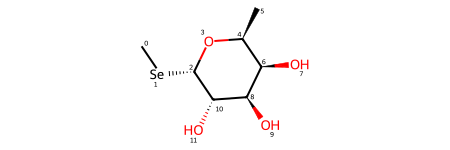

In [83]:
system_structure.input_ligand_templates[system_structure.ligand_chain_ordered[0]]

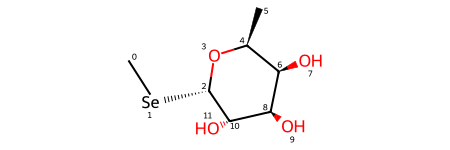

In [84]:
system_structure.input_ligand_conformers[system_structure.ligand_chain_ordered[0]]

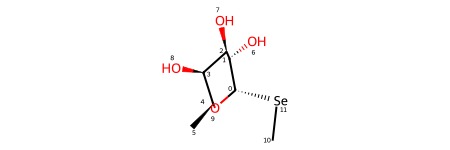

In [85]:
system_structure.resolved_ligand_mols[system_structure.ligand_chain_ordered[0]]

### Ligand conformer coordinates

As you can tell, the input 2D and 3D conformer indices match, but the resolved ligand is different.
Thus to perform a correct comparison for their coordinates one should use atom order stacks.


In [86]:
input_atom_order_stack, holo_atom_order_stack = system_structure.ligand_template2resolved_atom_order_stacks[system_structure.ligand_chain_ordered[0]]
input_atom_order_stack, holo_atom_order_stack

(array([[ 2, 10,  8,  6,  4,  5, 11,  9,  7,  3,  0,  1]]),
 array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]]))

In [87]:
system_structure.input_ligand_conformers_coords[system_structure.ligand_chain_ordered[0]][input_atom_order_stack]

array([[[-8.32246364e-01, -5.41422034e-01,  6.95310721e-01],
        [-9.61280066e-02, -1.62418779e+00, -2.58971617e-03],
        [ 1.36365688e+00, -1.29060539e+00, -8.72518051e-02],
        [ 1.65586502e+00,  1.44224780e-01, -2.81915007e-01],
        [ 5.19429961e-01,  1.07165352e+00, -3.06107763e-01],
        [ 9.64640937e-01,  2.38734569e+00,  3.55896266e-01],
        [-6.76487851e-01, -1.87751934e+00, -1.23675539e+00],
        [ 1.96517761e+00, -1.80232008e+00,  1.08687714e+00],
        [ 2.58306216e+00,  5.33170197e-01,  7.13728813e-01],
        [-6.37999839e-01,  7.13567855e-01,  2.76032171e-01],
        [-3.69851856e+00,  5.39740535e-01, -2.75985663e-01],
        [-2.75082421e+00, -9.41947345e-01,  5.22679063e-01]]])

In [88]:
system_structure.resolved_ligand_mols_coords[system_structure.ligand_chain_ordered[0]][holo_atom_order_stack]

array([[[48.954, 28.186, 62.068],
        [48.681, 29.643, 61.777],
        [48.556, 29.933, 60.282],
        [47.499, 28.988, 59.699],
        [47.948, 27.56 , 59.939],
        [46.992, 26.503, 59.374],
        [49.72 , 30.41 , 62.383],
        [48.255, 31.352, 60.148],
        [46.262, 29.193, 60.366],
        [48.031, 27.383, 61.339],
        [50.647, 25.895, 62.426],
        [50.853, 27.716, 61.696]]])

## Protein

In [90]:
for name in system_structure.get_properties():
    if "protein" in name:
        print(name)

protein_backbone_mask
protein_calpha_coords
protein_calpha_mask
protein_chain_ordered
protein_chains
protein_coords
protein_n_atoms
protein_sequence_from_structure
protein_structure_b_factor
protein_structure_tokenized_sequence
protein_unique_atom_names
protein_unique_residue_ids
protein_unique_residue_names


### Masking
The properties `protein_backbone_mask` and `protein_calpha_mask` are boolean masks that can be used to select backbone or calpha atoms from biotite `AtomArray`. The indices of `True` corresponds to backbone or calpha indices.

In [91]:
print(
    "Total number of atoms:",
    len(system_structure.protein_atom_array),
)
print(
    "Number of backbone atoms:",
    system_structure.protein_backbone_mask.sum()
)
print(
    "Number of calpha atoms:",
    system_structure.protein_calpha_mask.sum(),
)

Total number of atoms: 2443
Number of backbone atoms: 942
Number of calpha atoms: 314


In [92]:
calpha_atom_array = system_structure.protein_atom_array[system_structure.protein_calpha_mask]
calpha_atom_array.coord.shape


(314, 3)

You can also filter by arbitrary properties of the `AtomArray` using the `filter` method. This returns a new `Structure` object.

In [93]:
calpha_structure = system_structure.filter(
    property="atom_name",
    mask="CA",
)

2024-09-23 17:29:59,558 | plinder.core.structure.atoms:127 | WARNING : generate_conformer: MMFFOptimizeMolecule - the forcefield could not be set up


In [94]:
calpha_structure.protein_atom_array.coord.shape

(314, 3)

## Linked protein input structures

For realistic inference scenarios we need to initialize our protein structures using a linked structure (introduced above). In many structures the residue numbering varies, thus we do need to ensure correct residues and atom mapping.

In [95]:
#TODO:

#TODO: visuals?

# Datasets and Dataloaders

#### Interacting with the PLINDER dataset
`PlinderDataset` provides an interface to interact with _PLINDER_ data as a dataset. It is a subclass of `torch.utils.data.Dataset`, as such subclassing it and extending should be familiar to most users. Flexibility and general applicability is our top concern when designing this interface and `PlinderDataset` allows users to not only define their own split but to also bring their own featurizer.
It can be initialized with the following parameters
```
Parameters
    ----------
    df : pd.DataFrame | None
        the split to use
    split : str
        the split to sample from
    split_parquet_path : str | Path, default=None
        split parquet file
    input_structure_priority : str, default="apo"
        Which alternate structure to proritize
    featurizer: Callable[
            [Structure, int], dict[str, torch.Tensor]
    ] = structure_featurizer,
        Transformation to turn structure to input tensors
    padding_value : int
        Value for padding uneven array
    **kwargs : Any
        Any other keyword args
```

In [96]:
from plinder.core.loader.dataset import PlinderDataset, get_torch_loader

This is where you may want to load a `train` dataset, but for the purposes of demonstration - we will start with `val` due to smaller memory footprint.

In [97]:
val_dataset = PlinderDataset(split="val",
                               filters=[("system_num_protein_chains", "==", 1)])

In [98]:
val_dataset[2]

{'system_id': '7h3v__2__1.B__1.G',
 'holo_structure': Structure(
     (
         'id',
         '7h3v__2__1.B__1.G',
     ),
     (
         'protein_path',
         /content/plinder/2024-06/v2/systems/7h3v__2__1.B__1.G/receptor.cif,
     ),
     (
         'protein_sequence',
         {
             '1.B': 'QEQTGGSGAIYVGNYRVVNRHLATHNDWANLVWEDSSRDLLVSSTTAQGCDTIARCDCQTGVYYCSSRRKHYPVSFSKPSLIFVEASEYYPARYQSHLMLAVGHSEPGDCGGILRCQHGVVGIVSTGGNGLVGFADVRDLLWLDEEAMEQ',
         },
     ),
     (
         'ligand_sdfs',
         {
             '1.G': '/content/plinder/2024-06/v2/systems/7h3v__2__1.B__1.G/ligand_files/1.G.sdf',
         },
     ),
     (
         'ligand_smiles',
         {
             '1.G': 'COc1ccccc1-c1nnco1',
         },
     ),
     (
         'protein_atom_array',
         <class 'biotite.structure.AtomArray'> with shape (1083,),
     ),
     (
         'ligand_mols',
         {
             '1.G': (
                 (
                     <class 'numpy.ndarray'> with shape

In [99]:
val_loader = get_torch_loader(
    val_dataset
)

In [100]:
for data in val_loader:
    test_torch = data
    break

2024-09-23 17:37:19,823 | plinder.core.structure.atoms:207 | WARNING : get_template_to_mol_matches: could not match template fully - retry with unmatched bonds set as UNSPECIFIED
2024-09-23 17:37:20,700 | plinder.core.structure.atoms:133 | WARNING : generate_conformer: EmbedMolecule - failed, try using useBasicKnowledge=False
2024-09-23 17:37:22,334 | plinder.core.structure.atoms:207 | WARNING : get_template_to_mol_matches: could not match template fully - retry with unmatched bonds set as UNSPECIFIED


# Evaluation

## `plinder_eval`

We provide a wrapper around the OpenStructure scorer as well as PoseBusters to make it easy to evaluate predictions against PLINDER systems and generate scores for the leaderboard.


This can be accessed through the command-line tool `plinder_eval`





In [101]:
!plinder_eval --help

usage: 
    Evaluate a set of docking/cofolding predictions against a set of reference Plinder systems.
    

options:
  -h, --help            show this help message and exit
  --prediction_file PREDICTION_FILE
                        Path to prediction file with [id, reference_system_id, receptor_file,
                        ligand_file, rank, confidence] as columns
  --output_dir OUTPUT_DIR
                        Path to output folder where score JSON files are saved
  --num_processes NUM_PROCESSES
                        Number of processes to use
  --overwrite           Overwrite max similarity files
  --posebusters         Run posebuster scoring
  --flexible            Run protein scoring, for flexible docking and cofolding
  --posebusters_full    Run posebuster scoring and return full report


This expects a CSV file with each row representating a protein-ligand pose, and the following columns:

- `id`: An identifier for the prediction (same across different ranked poses of the same prediction)
- `reference_system_id`: `plinder` system ID to use as reference
- `receptor_file`: Path to predicted receptor CIF file. Leave blank if rigid docking, the system's receptor file will be used.
- `rank`: The rank of the predicted pose (1-indexed)
- `ligand_file`: Path to the SDF file of the predicted pose

And produces a `scores.parquet` file with evaluated metrics for all the poses.

For individual systems you can also use the Python function `plinder.eval.docking.write_scores.evaluate`

For example, here's how one could use AutoDock Vina to generate some docked poses from one of the apo/pred structures and then evaluate them:

In [102]:
from biotite.structure import centroid, from_template
import numpy as np
from biotite.application.autodock import VinaApp
from biotite.structure.io import load_structure
from biotite.structure.io.mol import MOLFile, SDFile
from rdkit import Chem
from pathlib import Path
from plinder.core import PlinderSystem
import tempfile


def vina(
    ligand,
    receptor,
    pocket_center,
    output_folder: Path,
    size=10,
    max_num_poses=5
):
    app = VinaApp(
        ligand,
        receptor,
        center=pocket_center,
        size=[size, size, size],
    )
    app.set_max_number_of_models(max_num_poses)
    app.start()
    app.join()
    docked_ligand = from_template(ligand, app.get_ligand_coord())
    docked_ligand = docked_ligand[..., ~np.isnan(docked_ligand.coord[0]).any(axis=-1)]
    output_files = []
    for i in range(docked_ligand.shape[0]):
        sdf_file = MOLFile()
        sdf_file.set_structure(docked_ligand[i])
        output_file = output_folder / f"docked_ligand_{i}.sdf"
        sdf_file.write(output_file)
        output_files.append(output_file)
    return output_files

def input_ligand_conformer_biotite(self):
      """dict[str, AtomArray]: The coordinates of the input 3D conformer generated from input SMILES"""
      ligands = {}
      for c in self.input_ligand_conformers:
          with tempfile.NamedTemporaryFile(suffix=".sdf") as tmp_file:
              Chem.SDWriter(tmp_file.name).write(self.input_ligand_conformers[c])
              ligands[c] = SDFile.read(tmp_file.name).record.get_structure()
      return ligands

In [103]:
from plinder.core.scores import query_index

In [104]:
val_set = query_index(splits=["val"], filters=[("system_num_ligand_chains", "==", 1), ("system_num_protein_chains", "==", 1)])

In [105]:
val_set

,system_id,entry_pdb_id,split
0,4cj6__1__1.A__1.B,4cj6,val
1,3cj9__1__1.A__1.D,3cj9,val
2,7da6__1__1.A__1.B,7da6,val
3,5dyw__1__1.A__1.E,5dyw,val
4,3bxm__1__2.A__2.C,3bxm,val
...,...,...,...
395,2vck__1__1.A__1.E,2vck,val
396,2vck__2__1.B__1.F,2vck,val
397,4k42__1__1.A__1.G,4k42,val
398,3elb__1__1.A__1.B,3elb,val


In [106]:
from plinder.core import PlinderSystem

plinder_system = PlinderSystem(system_id="4cj6__1__1.A__1.B")

In [107]:
apo_structures = plinder_system.alternate_structures

In [108]:
apo_structures.keys()

dict_keys(['P12271_A'])

In [109]:
apo_structure = apo_structures["P12271_A"]

In [110]:
input_protein = load_structure(apo_structure.protein_path, include_bonds=True, use_author_fields=False, model=1)
input_ligand_conformers = input_ligand_conformer_biotite(plinder_system.holo_structure)
input_ligand = input_ligand_conformers[plinder_system.holo_structure.ligand_chain_ordered[0]]

In [111]:
input_ligand.shape

(21,)

### Example: vina

In [ ]:
!mamba install -q vina

In [ ]:
output_folder = Path("test_output")
output_folder.mkdir(exist_ok=True)
docking_poses = vina(
    ligand=input_ligand,
    receptor=input_protein,
    pocket_center=centroid(input_protein),
    output_folder=output_folder,
    max_num_poses=5,
    size=20
)

/usr/local/lib/python3.10/site-packages/biotite/structure/io/pdbqt/file.py:403: UserWarning: A charge array was neither given as optional argument, nor does a charge annotation of the inserted AtomArray exist. Therefore, all atoms' formal charge is assumed to be zero.
  charges = partial_charges(atoms)


In [ ]:
from plinder.eval.docking.write_scores import evaluate

In [ ]:
metrics = []
for pose in docking_poses:
    metrics.append(
        evaluate(
            model_system_id=apo_structure.id,
            reference_system_id=plinder_system.system_id,
            receptor_file=apo_structure.protein_path,
            ligand_files=[pose],
            flexible=False,
            posebusters=False,
            posebusters_full=False,
        )
    )

In [ ]:
import pandas as pd
metrics_df = pd.DataFrame(metrics)
metrics_df


,model,reference,num_reference_ligands,num_model_ligands,num_reference_proteins,num_model_proteins,fraction_reference_ligands_mapped,fraction_model_ligands_mapped,lddt_pli_ave,lddt_pli_wave,lddt_lp_ave,lddt_lp_wave,bisy_rmsd_ave,bisy_rmsd_wave
0,P12271_A,4cj6__1__1.A__1.B,1,1,1,1,1.0,1.0,0.085754,0.085754,1.0,1.0,15.588256,15.588256
1,P12271_A,4cj6__1__1.A__1.B,1,1,1,1,1.0,1.0,0.082696,0.082696,1.0,1.0,12.258589,12.258589
2,P12271_A,4cj6__1__1.A__1.B,1,1,1,1,1.0,1.0,0.063703,0.063703,1.0,1.0,16.007225,16.007225
3,P12271_A,4cj6__1__1.A__1.B,1,1,1,1,1.0,1.0,0.104795,0.104795,1.0,1.0,15.785239,15.785239


In [ ]:
metrics_df[["reference", "lddt_pli_ave", "lddt_lp_ave", "bisy_rmsd_ave"]]

,reference,lddt_pli_ave,lddt_lp_ave,bisy_rmsd_ave
0,4cj6__1__1.A__1.B,0.085754,1.0,15.588256
1,4cj6__1__1.A__1.B,0.082696,1.0,12.258589
2,4cj6__1__1.A__1.B,0.063703,1.0,16.007225
3,4cj6__1__1.A__1.B,0.104795,1.0,15.785239


In [ ]:
metrics_full = []
for pose in docking_poses:
    metrics_full.append(
        evaluate(
            model_system_id=apo_structure.id,
            reference_system_id=plinder_system.system_id,
            receptor_file=apo_structure.protein_path,
            ligand_files=[pose],
            flexible=True,
            posebusters=True,
            posebusters_full=False,
        )
    )

[10:19:12] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[10:19:15] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[10:19:17] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[10:19:19] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.


In [ ]:
metrics_full = metrics[4:]

In [ ]:
metrics_df = pd.DataFrame(metrics_full)

In [ ]:
metrics_df[["reference", "lddt", "bb_lddt", 'per_chain_lddt_ave', 'per_chain_bb_lddt_ave', "lddt_pli_ave", "lddt_lp_ave", "bisy_rmsd_ave"]]

,reference,lddt,bb_lddt,per_chain_lddt_ave,per_chain_bb_lddt_ave,lddt_pli_ave,lddt_lp_ave,bisy_rmsd_ave
0,4cj6__1__1.A__1.B,1.0,1.0,1.0,1.0,0.085754,1.0,15.588256
1,4cj6__1__1.A__1.B,1.0,1.0,1.0,1.0,0.082696,1.0,12.258589
2,4cj6__1__1.A__1.B,1.0,1.0,1.0,1.0,0.063703,1.0,16.007225
3,4cj6__1__1.A__1.B,1.0,1.0,1.0,1.0,0.104795,1.0,15.785239


In [ ]:
metrics_df[[c for c in metrics_df.columns if c.startswith("posebusters")]]

,posebusters_mol_pred_loaded,posebusters_mol_cond_loaded,posebusters_sanitization,posebusters_inchi_convertible,posebusters_all_atoms_connected,posebusters_bond_lengths,posebusters_bond_angles,posebusters_internal_steric_clash,posebusters_aromatic_ring_flatness,posebusters_double_bond_flatness,posebusters_internal_energy,posebusters_protein-ligand_maximum_distance,posebusters_minimum_distance_to_protein,posebusters_minimum_distance_to_organic_cofactors,posebusters_minimum_distance_to_inorganic_cofactors,posebusters_minimum_distance_to_waters,posebusters_volume_overlap_with_protein,posebusters_volume_overlap_with_organic_cofactors,posebusters_volume_overlap_with_inorganic_cofactors,posebusters_volume_overlap_with_waters
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0


In [ ]:
view = py3Dmol.view()
view.setBackgroundColor('white')

view.setStyle({'stick': {'color':'green'}})
view.addModel(open(apo_structure.protein_path, 'r').read(),'cif')
view.setStyle({'chain':'A'}, {'cartoon': {'color':'blue'}})
view.addModel(open(docking_poses[-1], 'r').read(), 'sdf')


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [ ]:
view = py3Dmol.view()
view.setBackgroundColor('white')
view.addModel(open(plinder_system.system_cif, 'r').read(),'cif')
view.setStyle({'chain':plinder_system.holo_structure.protein_chain_ordered[0]}, {'cartoon': {'color':'purple'}})
view.setStyle({'chain':plinder_system.holo_structure.ligand_chain_ordered[0]}, {'stick': {'color':'green'}})
view.zoomTo()
view.show()

[10:29:23] Molecule does not have explicit Hs. Consider calling AddHs()
[10:29:23] Molecule does not have explicit Hs. Consider calling AddHs()


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## `plinder_stratify`

TODO:

## `plinder_plot`

# MLSB leaderboard checklist (TL;DR)

Assuming a single-ligand single-protein flexible pocket docking model

1. Get relevant train and val systems
e.g.

```python
train_systems = set(query_index(filters=[("system_num_ligand_chains", "==", 1),
 ("system_num_protein_chains", "==", 1)], splits=["train"])["system_id"])
val_systems = set(query_index(filters=[("system_num_ligand_chains", "==", 1),
 ("system_num_protein_chains", "==", 1)], splits=["val"])["system_id"])
 ```

 2. Train your model.
 - Make sure to only use apo/pred structures linked to the respective systems and not leak any val set systems into train.
 - If you have a pocket prediction component, make sure you're not leaking any info about the pocket from the ground truth protein or ligand. Use input conformers instead.
 - Evaluate model performance on the val set, both while monitoring training for early stopping and hyperparameter optimization etc. as well as using the full evaluation harness for some checkpoints, to ensure that you are predicting complexes with good poses, physics, pockets, interactions and global proteins.
 - Plot val set performance as a function of similarity to the training set to see if your model has some inductive biases.

 3. Expose a predict.py function and upload your model to HuggingFace for everyone to use! (next session)